In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.

In [6]:
import prettytensor as pt

In [7]:
tf.__version__

'0.12.1'

In [8]:
print(pt.__version__)

0.7.1


Load Data
=================


In [9]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [10]:
# Load Class-names
import pandas as pd
signnames1 = pd.read_csv('signnames.csv').values[:,1]
signnames = pd.read_csv('signnames.1.csv').values[:,1]
print(signnames1)
print("\nAbbreviated Sign names:\n\n")
print(signnames)

['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vehicles' 'Vehicles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road' 'Slippery road'
 'Road narrows on the right' 'Road work' 'Traffic signals' 'Pedestrians'
 'Children crossing' 'Bicycles crossing' 'Beware of ice/snow'
 'Wild animals crossing' 'End of all speed and passing limits'
 'Turn right ahead' 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vehicles over 3.5 metric tons']

Abbreviated Sign names:


['S L (2

In [11]:
images_train, cls_train = train['features'], train['labels']
images_test, cls_test = test['features'], test['labels']

In [12]:

#  Number of training examples
n_train = len(cls_train)

# TODO: Number of testing examples.
n_test = len(cls_test)

# TODO: What's the shape of an traffic sign image?
image_shape = images_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(cls_train))




print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [13]:
# One hot encode labels
def encode_labels(labels):
    labels = (np.arange(n_classes) == labels[:, None]).astype(np.float)
    return labels

In [14]:
labels_train = encode_labels(cls_train)
labels_test = encode_labels(cls_test)



In [15]:
labels_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.])

Data Dimensions
================

In [16]:
img_size = image_shape[0]
img_size

32

In [17]:
num_channels = image_shape[2]
num_channels

3

In [18]:
n_classes

43

In [19]:
# The images are 32x32 pixels, but We will crop them to 24x24 pixels
img_size_cropped = 24

Helper-Function for plotting images
===================================

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [20]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 3)
    
    # Adjust vertical spacing if we need to print ensemble and best net.
    if cls_pred is None:
        hspace = 0.3
        
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        
        if smooth:
            interpolation = 'spline16'
            
        else:
            interpolation = 'nearest'
            
        # Plot image
        ax.imshow(images[i, :, :, :], interpolation=interpolation)
        
        # Name of the true class.
        cls_true_name = signnames[cls_true[i]]
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
            
        else:
            # Name of the predicted class.
            cls_pred_name = signnames[cls_pred[i]]
            
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            
        # Show the classses as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
        
    # Ensure the plot is shown correctly with multiple plots
    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
    plt.show()

Plot a few images to see if data is correct
=============================================


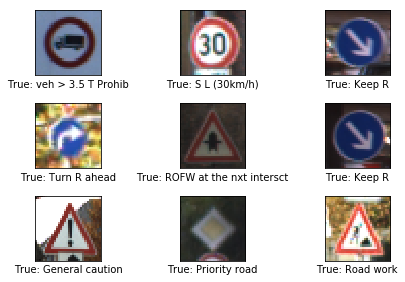

In [21]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above are what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

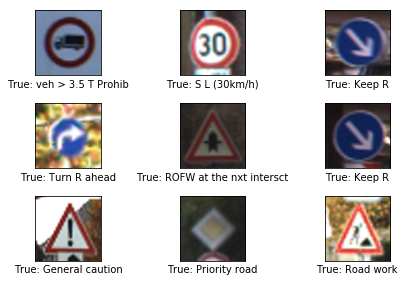

In [22]:
plot_images(images=images, cls_true=cls_true, smooth=True)

Tensorflow Graph
===================

Our TensorFlow Graph will consist of the following parts which will be detailed below:
- Placeholder variables used for inputting data to the graph.
- Variables that are going to be optimized so as to make the convolutional network perform better.
- The mathematical formulas for the convolutional network.
- A loss measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables.


1. Placeholder variables
=========================
First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. The data-type is set to float32 and the shape is set to [None, img_size, img_size, num_channels], where None means that the tensor may hold an arbitrary number of images with each image being img_size pixels high and img_size pixels wide and with num_channels colour channels.

In [23]:
X = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='X')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable X. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 43 in this case.

In [24]:
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')

In [25]:
# Use argmax to calculate the class_Number
y_true_cls = tf.argmax(y_true, dimension=1)

Helper-function for creating Pre-Processing
=============================================

The following helper-functions create the part of the TensorFlow computational graph that pre-processes the input images by adding nodes to the computational graph of TensorFlow.

The pre-processing is different for training and testing for our ConvNets:
- **For training:** the input images are randomly cropped, randomly flipped horizontally, and the hue, and contrast and saturation is adjust with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown below.
- **For testing:** the input images are cropped around the centre and nothing else is adjusted.

In [26]:
def pre_process_image(image, training):
    '''
    Args: - single image
          - Boolean: whether to build the training or testing graph
    Returns: a transformed image
    '''
    
    if training:
        # For training, add the following to the TensorFlow Graph
        
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        
        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
        
    else:
        # For testing, add the following to the TensorFlow Graph
        
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                      target_height = img_size_cropped,
                                                      target_weight = img_size_cropped)
        
        
    return image
    
    

The function above is called for each image in the input batch using the following function.

In [27]:
def pre_process(images, training):
    '''
    Args: - images
          - Boolean 
    
    Use Tensorflow to loop over all the input images and call the function
    above which takes a single image as input.
    
    '''
    
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow.

In [28]:
distorted_images = pre_process(images=X, training=True)

Helper-function for creating Main Processing
==============================================
The following helper-function creates the main part of the ConvNet. It uses [Pretty Tensor](https://github.com/google/prettytensor). Pretty Tensor provides a high level builder API for TensorFlow. It provides thin wrappers on Tensors so that you can easily build multi-layer neural networks.

In [29]:
def main_network(images, training):
    # wrap the input images as a Pretty Tensor object.
    X_pretty = pt.wrap(images)
    
    # Pretty Tensor uses special numbers to distinguish between the training and testing phases.
    if training:
        phase = pt.Phase.train
        
    else:
        phase = pt.Phase.infer
        
        
    # Create the ConvNet using Pretty Tensor.
    # Use batch-normalization in the first layer.
    
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = X_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=n_classes, labels=y_true)
            
    return y_pred, loss
    

Helper-function for creating Neural Network
==============================================

The following helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above. The neural network is enclosed in the variable-scope named 'network' because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [30]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = X
        
        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training = training)
        
        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss



Create Convolution Neural Network for Training Phase
=====================================================

First Create a TensorFlow variable that keeps track of the number of optimization iterations performed so far. 


In [31]:
# set trainable=False so that TensorFlow doesn't try to optimize global_step variable
global_step = tf.Variable(initial_value=0,
                         name='global_step', trainable=False)          

Create ConvNet to be used for training. The create_network() function returns both y_pred and loss, but we only need the loss-function during training.

In [32]:
_, loss = create_network(training=True)

- Create an Optimizer which will minimize the loss-function.
- Pass the global_step variable to the optimizer so it will be increased by one after each iteration.

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)